# Identify Fraud from Enron Email 

## Introduction

### Background
Enron Corporation was an American energy, commodities, and services company based in Houston, Taxas. At the end of 2001, it was revealed that its reported financial condition was sustained by institutionalized, systematic, and creatively planned accoung fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record. I will use my skills to analyze the data by building a person of interest identifier based on financial and email data.

### Data Exploration

The data contains many financial features and email features in the form of dictionary, where each key-value pair corresponds to one person.

Financial features contain: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

Email features contain: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

POI label contains: [‘poi’] (boolean, represented as integer)

In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
print len(data_dict)
print len(data_dict[data_dict.keys()[0]])

els = list(data_dict.items())
els[0]

Populating the interactive namespace from numpy and matplotlib
146
21


C:\Users\admin\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('METTS MARK',
 {'bonus': 600000,
  'deferral_payments': 'NaN',
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'mark.metts@enron.com',
  'exercised_stock_options': 'NaN',
  'expenses': 94299,
  'from_messages': 29,
  'from_poi_to_this_person': 38,
  'from_this_person_to_poi': 1,
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 1740,
  'poi': False,
  'restricted_stock': 585062,
  'restricted_stock_deferred': 'NaN',
  'salary': 365788,
  'shared_receipt_with_poi': 702,
  'to_messages': 807,
  'total_payments': 1061827,
  'total_stock_value': 585062})

There are 146 rows in the dataset and each data has in the total of 21 of financial and email features in the form of dictionary as shown above.

In [2]:
count = 0
for x in data_dict.iteritems():
    key, value = x
    for k, v in value.iteritems():
        if k == 'poi':
            if v == 1:
                count = count + 1
                print key
                
count

HANNON KEVIN P
COLWELL WESLEY
RIEKER PAULA H
KOPPER MICHAEL J
SHELBY REX
DELAINEY DAVID W
LAY KENNETH L
BOWEN JR RAYMOND M
BELDEN TIMOTHY N
FASTOW ANDREW S
CALGER CHRISTOPHER F
RICE KENNETH D
SKILLING JEFFREY K
YEAGER F SCOTT
HIRKO JOSEPH
KOENIG MARK E
CAUSEY RICHARD A
GLISAN JR BEN F


18

There are in total of 18 people of interest with the names listed above.

In [3]:
count_salary = 0
count_email = 0

for x in data_dict.iteritems():
    key, value = x
    for k, v in value.iteritems():
        if k == 'salary':
            if v != 'NaN':
                count_salary = count_salary + 1
        if k == 'email_address':
            if v != 'NaN':
                count_email = count_email + 1
                
            
                
print count_salary, count_email

95 111


There are 95 people who do not have data in the column of salary, and 111 people in the column of email address.

## Investigate the data

### Outliers

Before starting to test classifiers, I will try to find if there is any outlier, and if there is, try to find out what causes it and how I can handle it.

First thing is to see the salary and bonus.

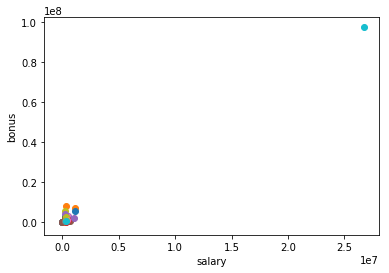

In [4]:
features_list = ['poi','salary','bonus','total_payments','exercised_stock_options']
data = featureFormat(data_dict, features_list)
### plot features
for point in data:
    salary = point[1]
    bonus = point[2]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")

By looking up the data, I could find out that Total is just a spreadsheet quirk, so I will take it out and create plot again.

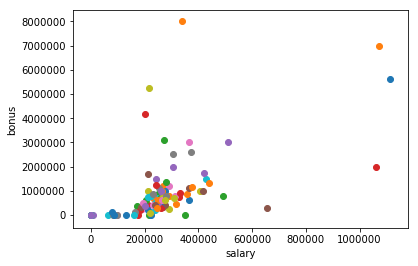

In [5]:
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features_list)

for point in data:
    salary = point[1]
    bonus = point[2]
    plt.scatter( salary, bonus )
    
plt.xlabel("salary")
plt.ylabel("bonus")

I can still see 4 more points that can be considered as outliers, so I will try to find them by using the python code.

In [6]:
for k, v in data_dict.iteritems():
    for key, value in v.iteritems():
        if key == 'salary':
            if value > 1000000:
                if value != 'NaN':
                    print k, key, value
        elif key == 'bonus':
            if value > 7000000:
                if value != 'NaN':
                    print k, key, value

LAVORATO JOHN J bonus 8000000
LAY KENNETH L salary 1072321
SKILLING JEFFREY K salary 1111258
FREVERT MARK A salary 1060932


I could find outliers' names, which include Jeffrey K Skilling and Kenneth L Lay who are also in the list of POI.

Next thing is to see the total payment and exercised stock option.

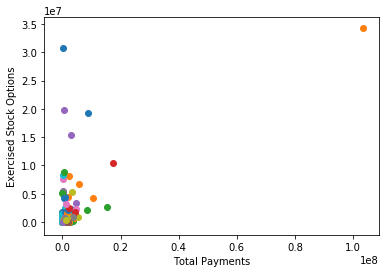

In [7]:
data_dict.pop('TOTAL', 0)

for point in data:
    total_payments = point[3]
    exercised_stock_options = point[4]
    plt.scatter( total_payments, exercised_stock_options )

plt.xlabel("Total Payments")
plt.ylabel("Exercised Stock Options")

I can see a huge outlier, even after I removed Total column.

In [8]:
for k, v in data_dict.iteritems():
    for key, value in v.iteritems():
        if key == 'total_payments':
            if value > 17000000:
                if value != 'NaN':
                    print k, key, value
        elif key == 'exercised_stock_options':
            if value > 10000000:
                if value != 'NaN':
                    print k, key, value

LAY KENNETH L total_payments 103559793
LAY KENNETH L exercised_stock_options 34348384
RICE KENNETH D exercised_stock_options 19794175
SKILLING JEFFREY K exercised_stock_options 19250000
HIRKO JOSEPH exercised_stock_options 30766064
FREVERT MARK A total_payments 17252530
FREVERT MARK A exercised_stock_options 10433518
PAI LOU L exercised_stock_options 15364167


I can see that the huge outlier is Kenneth L Lay, had $ 103,559,793. 

The next person who had the highest total payment had $ 17,253,530, showing that how relatively high that outlier is. On the other hand, there are also many outliers (though not much as that huge outlier) in the column of exercised stock options, which include Kenneth L Lay and Jeffrey K Skilling again, and others. Among them, Kenneth D Rice and Joseph Hirko is also in the list of POI. It is interesting that Mark A Frevert is in the list of outliers for total payments, exercised stock options, and salary, but he wasn't in the list of POI.

### Processing the data

For processing the data, I will use feature scaling using MinMaxScaler. By doing so, I can transform the data and use very small standard deviations of features and preserving zero entries in sparse data. For example, the maximum of email features is less than a thousand, but the maximum of salary is more than millions, but by doing so I can compare them easily. It is processed as following:

In [9]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

stock_fromPOI = []
for i in data_dict:
    if (data_dict[i]['from_poi_to_this_person']=='NaN'):
        #stock.append(0.0)
        pass
    else:    
        stock_fromPOI.append(float(data_dict[i]['from_poi_to_this_person']))

len(stock_fromPOI)

86

In [10]:
stock_toPOI = []
for i in data_dict:
    if (data_dict[i]['from_this_person_to_poi']=='NaN'):
        #stock.append(0.0)
        pass
    else:    
        stock_toPOI.append(float(data_dict[i]['from_this_person_to_poi']))

len(stock_toPOI)

86

Since from_this_person_to_poi and from_poi_to_this_person have same number of rows after excluding NaN values, and the number matters rather than the fact if it is from POI or to POI, I will create a new column named 'from_to_poi' and combine the number of those, and do transforming again.

In [11]:
for i in data_dict:
    data_dict[i]['from_to_poi'] = data_dict[i]['from_this_person_to_poi'] + data_dict[i]['from_poi_to_this_person']
    if data_dict[i]['from_to_poi'] == 'NaNNaN':
        data_dict[i]['from_to_poi'] = 'NaN'

els = list(data_dict.items())
els[0]

stock_fromtoPOI = []
for i in data_dict:
    if (data_dict[i]['from_to_poi']=='NaN'):
        pass
    else:    
        if (data_dict[i]['salary']=='NaN'):
            pass
        else:
            stock_fromtoPOI.append(float(data_dict[i]['from_to_poi']))

fromtoPOI_train_minmax = min_max_scaler.fit_transform(stock_fromtoPOI)
fromtoPOI_train_minmax

C:\Users\admin\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\admin\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 0.04153355,  0.05644302,  0.08945687,  0.11608094,  0.02875399,
        0.01277955,  0.02875399,  0.05324814,  0.26730564,  0.01277955,
        0.04685836,  0.01810437,  0.47390841,  0.1884984 ,  0.00425985,
        0.03301384,  0.08839191,  0.56443024,  0.04366347,  0.08626198,
        1.        ,  0.04153355,  0.14802982,  0.0543131 ,  0.02875399,
        0.12673056,  0.22364217,  0.30457934,  0.71884984,  0.14802982,
        0.0372737 ,  0.05537806,  0.25665602,  0.16506922,  0.00958466,
        0.26943557,  0.35782748,  0.11608094,  0.        ,  0.23855165,
        0.04898829,  0.2257721 ,  0.00425985,  0.1256656 ,  0.00745474,
        0.56123536,  0.03088392,  0.11927583,  0.03194888,  0.03833866,
        0.        ,  0.01384452,  0.03940362,  0.01384452,  0.33972311,
        0.08945687,  0.26411076,  0.08413206,  0.07241747,  0.03514377,
        0.02236422,  0.0085197 ,  0.24174654,  0.07454739,  0.        ,
        0.21192758,  0.06176784])

In [12]:
stock = []
for i in data_dict:
    if (data_dict[i]['salary']=='NaN'):
        pass
    else:
        if (data_dict[i]['from_to_poi']=='NaN'):
            pass
        else:
            stock.append(float(data_dict[i]['salary']))

salary_train_minmax = min_max_scaler.fit_transform(stock)
salary_train_minmax

C:\Users\admin\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\admin\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 0.32887761,  0.21859935,  0.33307286,  0.17700519,  0.11725714,
        0.25937786,  0.22332845,  0.23137684,  0.25933555,  0.22612648,
        0.25934995,  0.32104798,  0.24394097,  0.27335091,  0.16875064,
        0.19189021,  0.22391813,  0.20782945,  0.19023642,  0.24601519,
        0.30502052,  0.        ,  0.24181094,  0.38558726,  0.19028683,
        0.1851346 ,  0.45903468,  0.32820241,  0.32831494,  0.96494629,
        0.29582879,  0.23671273,  0.33638314,  0.25038599,  0.17886514,
        0.08675247,  0.19222691,  0.18924973,  0.19951368,  0.21580492,
        0.37825548,  0.24723505,  0.28251383,  1.        ,  0.58927907,
        0.36358292,  0.23363651,  0.18138409,  0.22296834,  0.2352687 ,
        0.22285221,  0.2059875 ,  0.20838401,  0.19853238,  0.22472747,
        0.44283977,  0.95469314,  0.27378124,  0.27860487,  0.07633998,
        0.22224093,  0.31420235,  0.29715038,  0.37335172,  0.23833411,
        0.25038599,  0.24712162])

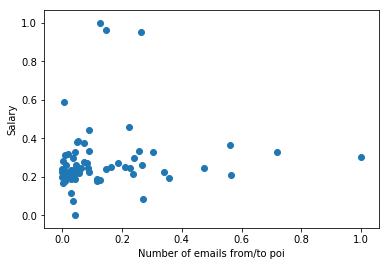

In [13]:
plt.scatter(fromtoPOI_train_minmax, salary_train_minmax)

plt.xlabel("Number of emails from/to poi")
plt.ylabel("Salary")

I can see some relations but not strong enough to consider, so at this time I will add 'shared_receipt_with_poi' as well.

C:\Users\admin\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\admin\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


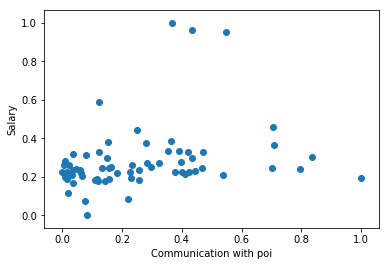

In [14]:
for i in data_dict:
    data_dict[i]['communication_with_poi'] = data_dict[i]['from_to_poi'] + data_dict[i]['shared_receipt_with_poi']
    if data_dict[i]['communication_with_poi'] == 'NaNNaN':
        data_dict[i]['communication_with_poi'] = 'NaN'

stock_POI = []
for i in data_dict:
    if data_dict[i]['communication_with_poi']=='NaN':
        pass
    else:    
        if (data_dict[i]['salary']=='NaN'):
            pass
        else:
            stock_POI.append(float(data_dict[i]['communication_with_poi']))

POI_train_minmax = min_max_scaler.fit_transform(stock_POI)

plt.scatter(POI_train_minmax, salary_train_minmax)

plt.xlabel("Communication with poi")
plt.ylabel("Salary")

Now I could see somewhat a stronger relation. I will do a simple test if it works

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

features_list = ['poi', 'communication_with_poi']
data = featureFormat(data_dict, features_list)

labels, features = targetFeatureSplit(data)
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.8, random_state=42)

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

print 'Accuracy =', accuracy_score(pred, labels_test)
print 'Precision =', precision_score(labels_test,pred)
print 'Recall =', recall_score(labels_test,pred)

Accuracy = 0.768115942029
Precision = 0.222222222222
Recall = 0.181818181818


In [16]:
features_list = ['poi', 'from_poi_to_this_person','from_this_person_to_poi','shared_receipt_with_poi']
data = featureFormat(data_dict, features_list)

labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.8, random_state=42)

clf = KNeighborsClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

print 'Accuracy =', accuracy_score(pred, labels_test)
print 'Precision =', precision_score(labels_test,pred)
print 'Recall =', recall_score(labels_test,pred)

Accuracy = 0.753623188406
Precision = 0.2
Recall = 0.181818181818


I can see a slightly higher accuracy and precision from new feature, thus it has a good impact on my algorithm.

## Pick and Tune an Algorithm

There are many kinds of algorithm, and I will try each of them and see which one has the best accuracy.

At first, I pick all the possible features, excluding poi and those that is combined in 'communication_with_poi' above, in total of 14, and see importances of each features, then select from them.

In [17]:
features_list = ['poi', 'salary', 'bonus', 'communication_with_poi', 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'director_fees']

data = featureFormat(data_dict, features_list)

labels, features = targetFeatureSplit(data)

from sklearn.feature_selection import SelectKBest

features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf = clf.fit(features_train, labels_train)

importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

for i in range(14):
    print "{} : {}".format(features_list[i+1],importances[indices[i]])

salary : 0.16
bonus : 0.14
communication_with_poi : 0.14
deferral_payments : 0.12
total_payments : 0.1
loan_advances : 0.1
restricted_stock_deferred : 0.08
deferred_income : 0.06
total_stock_value : 0.06
expenses : 0.02
exercised_stock_options : 0.02
long_term_incentive : 0.0
restricted_stock : 0.0
director_fees : 0.0


None of features had higher than 0.2 importance. 

Higher importance means how much that specific feature affects the decision to flag as POI or not. For example, salary with 0.16 importance affect x2 more than restricted stock deferred. Other example is, long term incentive, restricted stock, and director fees with 0 importance affect nothing or very insignificantly for the decision.

As shown above, salary is the most important feature, and bonus is the second most important feature. Communication with POI, my own defined attribute, and the sum of from_poi_to_this_person, from_this_person_to_poi, and shared_receipt_with_poi, is the third most important feature.

Back to the feature selection, I would pick the top 4 features, which have >.1 importance. Simply calculating combination of those 4 features affect more than (0.16+0.14+0.14+0.12+0.1+0.1) = 0.76 importance, more than three quaters.

In [18]:
features_list = ['poi', 'salary', 'bonus', 'communication_with_poi', 'deferral_payments', 'total_payments', 'loan_advances']

Now I will test various kind of classifiers.

In [19]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.fit(features_test, labels_test)
acc_NB = pred.score(features_test, labels_test)

print acc_NB

0.933333333333


In [20]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc_SVC = accuracy_score(pred, labels_test)
print acc_SVC

0.733333333333


In [21]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc_tree = accuracy_score(pred, labels_test)
print acc_tree

0.733333333333


In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc_rfc = accuracy_score(pred, labels_test)
print acc_rfc

0.733333333333


In [23]:
clf = AdaBoostClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc_abc = accuracy_score(pred, labels_test)
print acc_abc

0.866666666667


In [24]:
clf = KNeighborsClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc_knn = accuracy_score(pred, labels_test)
print acc_knn

0.8


As shown above, Naive Bayes has the best accuracy. Next one is to tune and make a ranking of importance of each feature. Since GaussianNB does not have this function, I will use the next most accurate classifier: AdaBoostClassifier.

Next step is to tuning my algorithm. Each of classifier has its own parameters, and it decides its behavior when trying to execute the algorithm. Well-tuned parameters may take less time to execute or give the best accuracy the classifier might have, and badly-tuned parameter may take more time or give worse accuracy.

There are some ways to tune AdaBoostClassifier, including n_estimators, learning_rate, algorithm, random_state. By tuning the algorithm, I can possibly get a better accuracy.

In [25]:
clf = AdaBoostClassifier(n_estimators=79, learning_rate=1, algorithm='SAMME.R', random_state=None)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc_abc = accuracy_score(pred, labels_test)
print 'Accuracy =', acc_abc

Accuracy = 0.933333333333


After I tuned the classifier, I could get the better accuracy (0.867 -> 0.933)

Each parameter gives me the following result:

n_estimators: highest from 79 (0.933), mid from 2 to 3, 6, 8, and from 32 to 66 (0.867), then low in other numbers.

learning_rate: does not affect the accuracy

algorithm: higher with SAMME.R, lower with SAMME

random_state: does not affect the accuracy

## Validate and Evaluate

At the end of project, I will perform validation and evaluation. 

Validation, in this case train_test_split, a kind of holdout validation, is a model evaluation method that split the data into two parts, one for training as training set, the other one for testing as testing set. It is important to avoid overfitting, which means, getting a perfect score so that fail to predict anything useful.

Evaluation will be performed with precision score and recall score, which precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

Testing, validating, and evaluating can be explained with the following code and output:

In [26]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.15, random_state=42)

clf_test = AdaBoostClassifier()
clf_test.fit(features_train, labels_train)
pred = clf_test.predict(features_test)

acc_test = accuracy_score(pred, labels_test)
print 'Accuracy before turning =', acc_test

clf_test2 = AdaBoostClassifier(n_estimators=79)
clf_test2.fit(features_train, labels_train)
pred2 = clf_test2.predict(features_test)

acc_test2 = accuracy_score(pred2, labels_test)
print 'Accuracy after turning =', acc_test2

print 'Precision =', precision_score(labels_test,pred)
print 'Recall =', recall_score(labels_test,pred)

dump_classifier_and_data(clf, data_dict, features_list)

Accuracy before turning = 0.909090909091
Accuracy after turning = 0.954545454545
Precision = 0.75
Recall = 0.75


I can see the accuracy after tuning is higher than accuracy before tuning. Recall is true positive / (true positive + false negative), and precision is true positive / (true positive + false positive). Both are 0.75, which means (POI flagged correctly)/(POI flagged correctly + POI not flagged incorrecly) and (POI flagged correctly)/(POI flagged correctly + not POI flagged incorrectly) are 0.75, which are high enough to be considered.

# Conclusion

My Adaboost algorithm with user defined attribute has made a highly accurated result of 0.933 with a few tuning parameters.

I could improve my algorithm if there were a lot more data, especially those data which are flagged as POI. There are only 146 rows, and only 18 POI people, which can be considered as imbalanced data.

In [30]:
%run poi_id.py

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.85633	Precision: 0.44364	Recall: 0.30500	F1: 0.36148	F2: 0.32533
	Total predictions: 15000	True positives:  610	False positives:  765	False negatives: 1390	True negatives: 12235



In [28]:
%run tester.py

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.85633	Precision: 0.44355	Recall: 0.30450	F1: 0.36110	F2: 0.32487
	Total predictions: 15000	True positives:  609	False positives:  764	False negatives: 1391	True negatives: 12236

